# Castile and Leon: Crops

### Description:
TODO

### Author:
Sergio García Prado ([garciparedes.me](https://garciparedes.me))

In [1]:
rm(list = ls())

In [2]:
library(readr)
library(ggplot2)
library(dplyr)
library(tidyr)
library(RSocrata)
library(ca)
library(forcats)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Data Adquisition:

In [3]:
my.read.csv <- function(url, filename) {
    if (!file.exists(filename)) {
        write_csv(read.socrata(url), filename)
    }
    return(read_csv(filename))
}

In [4]:
crops.herbaceous <- my.read.csv("https://analisis.datosabiertos.jcyl.es/resource/agu2-cspz.csv",
                               "./data/crops-herbaceous.csv")

Parsed with column specification:
cols(
  a_o = col_integer(),
  codigo_comarca = col_integer(),
  codigo_muncipio = col_integer(),
  codigo_producto = col_character(),
  codigo_provincia = col_integer(),
  comarca = col_character(),
  cultivo = col_character(),
  grupo_de_cultivo = col_character(),
  municipio = col_character(),
  ocupaci_n_primera_regad_o = col_integer(),
  ocupaci_n_primera_secano = col_integer(),
  ocupaciones_asociadas_regad_o = col_character(),
  ocupaciones_asociadas_secano = col_character(),
  ocupaciones_posteriores_regad_o = col_character(),
  ocupaciones_posteriores_secano = col_character()
)


In [5]:
crops.woody <- my.read.csv("https://analisis.datosabiertos.jcyl.es/resource/2vwa-si9n.csv",
                           "./data/crops-woody.csv")

Parsed with column specification:
cols(
  a_o = col_datetime(format = ""),
  codigo_comarca = col_integer(),
  codigo_muncipio = col_integer(),
  codigo_producto = col_character(),
  codigo_provincia = col_integer(),
  comarca = col_character(),
  cultivo = col_character(),
  grupo_de_cultivo = col_character(),
  municipio = col_character(),
  n_total_arboles_diseminados = col_integer(),
  superficie_regad_o_en_producci_n = col_integer(),
  superficie_regad_o_que_no_pruduce = col_integer(),
  superficie_secano_en_producci_n = col_integer(),
  superficie_secano_que_no_pruduce = col_integer()
)


## Data Exploration:

In [6]:
colnames(crops.herbaceous)

[1] "a_o"                             "codigo_comarca"                 
 [3] "codigo_muncipio"                 "codigo_producto"                
 [5] "codigo_provincia"                "comarca"                        
 [7] "cultivo"                         "grupo_de_cultivo"               
 [9] "municipio"                       "ocupaci_n_primera_regad_o"      
[11] "ocupaci_n_primera_secano"        "ocupaciones_asociadas_regad_o"  
[13] "ocupaciones_asociadas_secano"    "ocupaciones_posteriores_regad_o"
[15] "ocupaciones_posteriores_secano"

#### Remove Unnecesary Columns and Rename Interesting Columns

In [7]:
code.province.to.province <- function(code) {
    return(switch(as.character(code),
           "47" = "Valladolid",
           "24" = "León",
           "34" = "Palencia",
           "37" = "Salamanca",
           "9"  = "Burgos",
           "49" = "Zamora",
           "5"  = "Ávila",
           "42" = "Soria",
           "40" = "Segovia"))
}

In [8]:
crops.herbaceous.use <- crops.herbaceous %>%
    select(a_o, codigo_provincia:ocupaci_n_primera_secano) %>%
    rename(year = a_o, 
           code.province = codigo_provincia, 
           region = comarca, 
           crop = cultivo, 
           crop.type = grupo_de_cultivo, 
           town = municipio, 
           area.irrigation = ocupaci_n_primera_regad_o, 
           area.dry = ocupaci_n_primera_secano) %>%
    mutate(province = sapply(code.province,code.province.to.province)) %>%
    select(-code.province)

#### View Data Sample

In [9]:
sample_n(crops.herbaceous.use, 10)

year,region,crop,crop.type,town,area.irrigation,area.dry,province
2013,CAMPOS,AVENA,CEREALES GRANO,ASTUDILLO,NA,77,Palencia
2015,ARLANZON,ALFALFA,CULTIVOS FORRAJEROS,CAYUELA,7,NA,Burgos
2012,CENTRO I,ALFALFA,CULTIVOS FORRAJEROS,CASTRONUEVO DE ESGUEVA,17,76,Valladolid
2012,DUERO BAJO,COLZA,CULTIV. INDUSTRIALES,CASASECA DE CAMPEAN,2,100,Zamora
2010,ARLANZA,GARBANZO,LEGUMINOSAS GRANO,CEBRECOS,NA,11,Burgos
2012,CAMPO DE GOMARA,TRIGO,CEREALES GRANO,VELILLA DE LA SIERRA,66,280,Soria
2014,PEÑARADA DE BRACAMONTE,GIRASOL,CULTIV. INDUSTRIALES,PEÑARANDA DE BRACAMONTE,0,20,Salamanca
2014,SAYAGO,CARDO Y OTROS FORRAJ,CULTIVOS FORRAJEROS,BERMILLO DE SAYAGO,0,15,Zamora
2016,CAMPO DE GOMARA,ESPARCETA,CULTIVOS FORRAJEROS,ALMAJANO,0,1,Soria
2012,AVILA,VEZA,LEGUMINOSAS GRANO,ZAPARDIEL DE LA CAÑADA,NA,2,Ávila


In [10]:
summary(crops.herbaceous.use)

      year         region              crop            crop.type        
 Min.   :2010   Length:157965      Length:157965      Length:157965     
 1st Qu.:2011   Class :character   Class :character   Class :character  
 Median :2013   Mode  :character   Mode  :character   Mode  :character  
 Mean   :2013                                                           
 3rd Qu.:2015                                                           
 Max.   :2016                                                           
                                                                        
     town           area.irrigation      area.dry         province        
 Length:157965      Min.   :   0.00   Min.   :    0.0   Length:157965     
 Class :character   1st Qu.:   0.00   1st Qu.:    3.0   Class :character  
 Mode  :character   Median :   3.00   Median :   18.0   Mode  :character  
                    Mean   :  29.76   Mean   :  119.9                     
                    3rd Qu.:  19.00   3rd

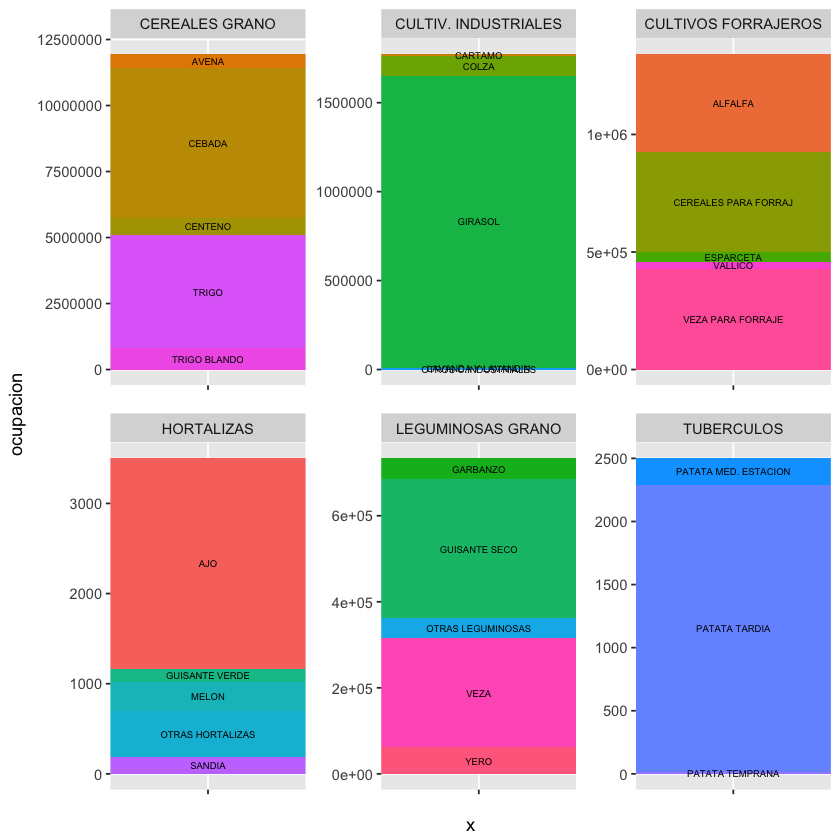

In [11]:
crops.herbaceous.use %>%
    select(crop, crop.type, area.dry) %>%
    filter(area.dry > 0) %>%
    group_by(crop.type, crop) %>%
    summarise(ocupacion = sum(area.dry, na.rm = TRUE)) %>%
    top_n(5, ocupacion) %>%
    ggplot(aes(x = "", y = ocupacion, fill = crop, label = crop)) + 
        geom_bar(width = 1, , stat="identity") +
        guides(fill=guide_legend(ncol=2)) +
        theme(legend.position='none') + 
        facet_wrap(~crop.type, scales = "free")+ 
        geom_text(size = 2, position = position_stack(vjust = 0.5)) 

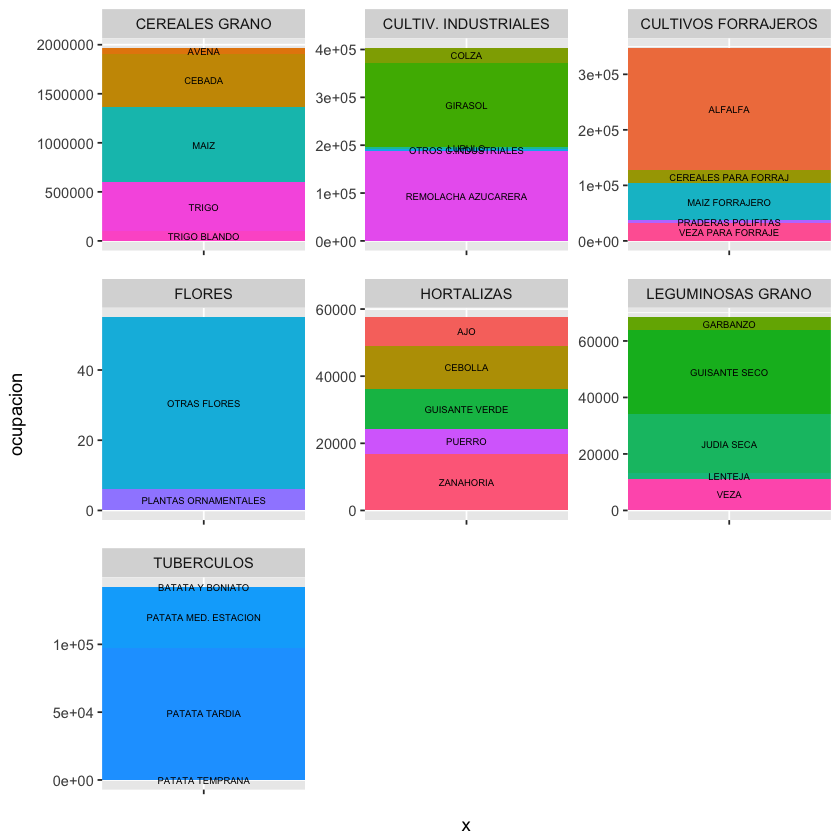

In [12]:
crops.herbaceous.use %>%
    select(crop, crop.type, area.irrigation) %>%
    filter(area.irrigation > 0) %>%
    group_by(crop.type, crop) %>%
    summarise(ocupacion = sum(area.irrigation, na.rm = TRUE)) %>%
    top_n(5, ocupacion) %>%
    ggplot(aes(x = "", y = ocupacion, fill = crop, label = crop)) + 
        geom_bar(width = 1, , stat="identity") +
        guides(fill=guide_legend(ncol=2)) +
        theme(legend.position='none') + 
        facet_wrap(~crop.type, scales = "free")+ 
        geom_text(size = 2, position = position_stack(vjust = 0.5)) 

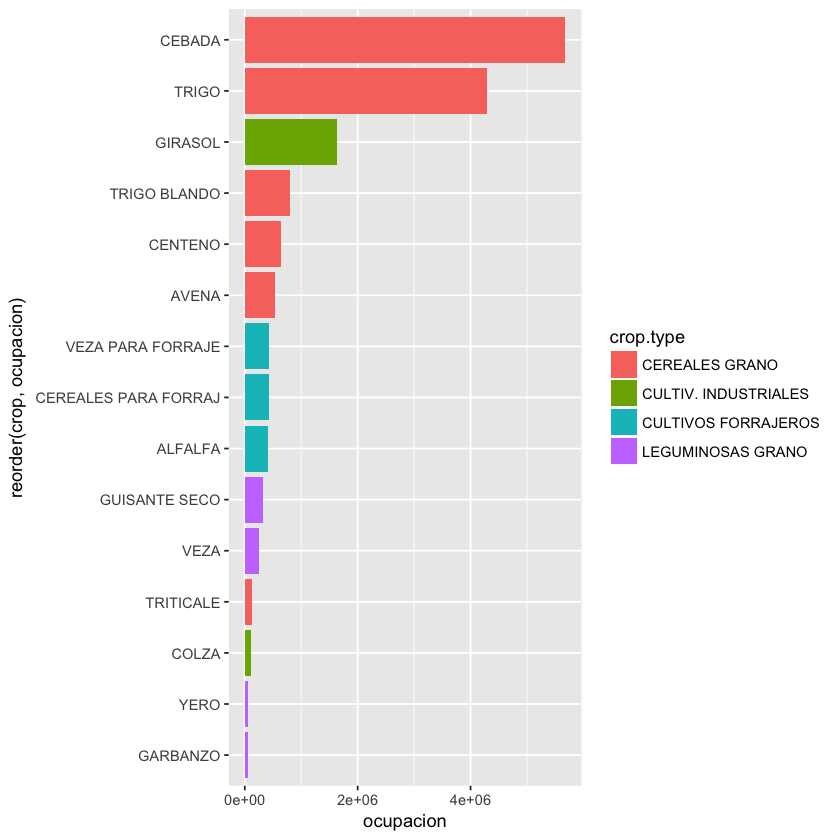

In [13]:
crops.herbaceous.use %>%
  select(crop, crop.type, area.dry) %>%
  filter(area.dry > 0) %>%
  group_by(crop.type, crop) %>%
  summarise(ocupacion = sum(area.dry, na.rm = TRUE)) %>%
  ungroup() %>%
  top_n(15, ocupacion) %>%
  ggplot(aes(x = reorder(crop, ocupacion), y = ocupacion)) + 
    geom_bar(aes(fill = crop.type), stat = "identity") + 
    coord_flip()

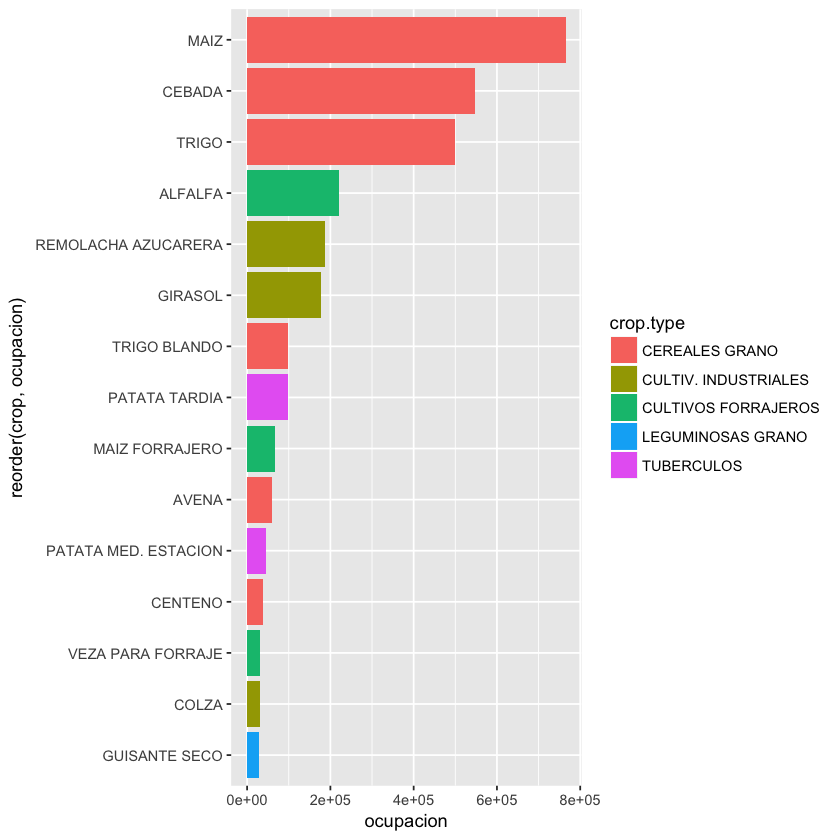

In [14]:
crops.herbaceous.use %>%
  select(crop, crop.type, area.irrigation) %>%
  group_by(crop.type, crop) %>%
  summarise(ocupacion = sum(area.irrigation, na.rm = TRUE)) %>%
  ungroup() %>%
  top_n(15, ocupacion) %>%
  ggplot(aes(x = reorder(crop, ocupacion), y = ocupacion)) + 
    geom_bar(aes(fill = crop.type), stat = "identity") + 
    coord_flip()

### Correspondence Analysis

In [15]:
crops.herbaceous.use.ca <- crops.herbaceous.use %>%
    select(crop.type, province, area.dry) %>%
    filter(area.dry > 0) %>%
    xtabs(formula = area.dry ~ .) %>%
    ca()

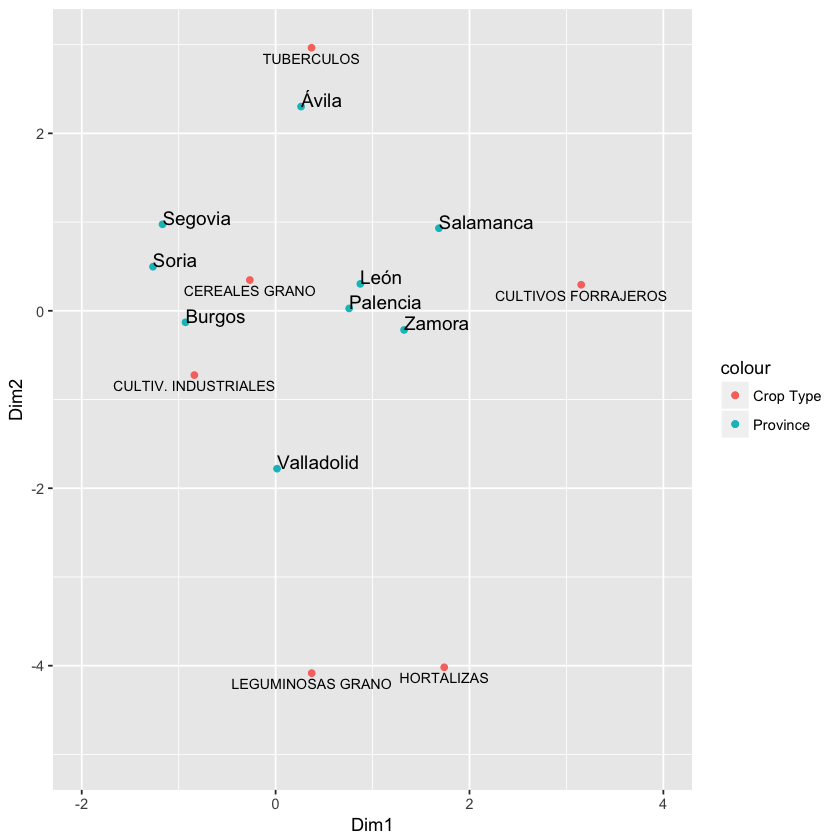

In [16]:
ggplot(mapping = aes(x =Dim1, y = Dim2 )) +
    geom_point(data = as.data.frame(crops.herbaceous.use.ca$colcoord), 
               mapping = aes(colour = 'Province')) + 
    geom_point(data = as.data.frame(crops.herbaceous.use.ca$rowcoord), 
               mapping = aes(colour = 'Crop Type')) + 
    geom_text(data = as.data.frame(crops.herbaceous.use.ca$rowcoord),
              label=rownames(crops.herbaceous.use.ca$rowcoord), 
              hjust=0.5, vjust=1.5, size = 3) +
    geom_text(data = as.data.frame(crops.herbaceous.use.ca$colcoord),
              label=rownames(crops.herbaceous.use.ca$colcoord), 
              hjust=0, vjust=0, size = 4) +
    coord_cartesian(xlim = c(-2, 4), ylim = c(-5, 3)) 
